In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from functools import partial

In [3]:
# The goal is to implement hooks into the model layers and visualize their performance 

## Download Dataset

In [4]:
# Download a dataset to train
from fastai import datasets
import gzip
import pickle

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

def get_data():
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(torch.tensor, (x_train,y_train,x_valid,y_valid))

x_train,y_train,x_valid,y_valid = get_data()

In [5]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

(torch.Size([50000, 784]),
 torch.Size([50000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

## Load Data

In [6]:
class MNIST_Dataset(Dataset):
    """This class holds and resizes MNIST datasets."""
    
    def __init__(self, x, y):
        self.x = self.mnist_resize(x)
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
            return self.x[i], self.y[i]  
        
    def mnist_resize(self,x):
        return x.view(-1,1,28,28)

In [7]:
ds_train = MNIST_Dataset(x_train,y_train)
ds_valid = MNIST_Dataset(x_valid,y_valid)

dl_train = DataLoader(ds_train, batch_size=512, shuffle=True)

## Model

In [8]:
class Lambda(nn.Module):
    """This class 'simulates' a Pytorch nn layern and allows to insert functions with
    a single input and single output.
    """
    
    def __init__(self,func):
        super().__init__()
        self.func = func
        
    def __call__(self,x):
        return self.func(x)

In [9]:
def flatten(x):
    return x.view(x.shape[0],-1)

In [10]:
x_flatten = flatten(torch.Tensor(100,32,1,1))
x_flatten.shape

torch.Size([100, 32])

In [11]:
model = nn.Sequential(
            nn.Sequential(nn.Conv2d(1, 8, 5, stride=2, padding=2), nn.LeakyReLU(negative_slope=0.1)), #14
            nn.Sequential(nn.Conv2d(8, 16, 3, stride=1, padding=2), nn.LeakyReLU(negative_slope=0.1)), #7
            nn.Sequential(nn.Conv2d(16, 32, 3, stride=1, padding=2), nn.LeakyReLU(negative_slope=0.1)), #4
            nn.Sequential(nn.Conv2d(32, 32, 3, stride=1, padding=2), nn.LeakyReLU(negative_slope=0.1)), #2
            nn.AdaptiveAvgPool2d(1),
            Lambda(flatten),
            nn.Linear(32,10)
        )
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [12]:
# Initialize the random weights with Kaiming
for l in model:
    if isinstance(l, nn.Sequential):
        nn.init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

## Training Loop

In [25]:
# Initialize Optimizer, Loss Function

opt = torch.optim.SGD(model.parameters(), lr = 0.1)
loss_func = F.cross_entropy

def accuracy(pred, yb): 
    return (torch.argmax(pred, dim=1)==yb).float().mean()

In [22]:
# Training loop 
epochs = 1

def fit(epochs, dataloader):  
    for i in range(epochs):
        for xb, yb in dataloader:
            pred = model(xb)
            loss = loss_func(pred,yb)
            loss.backward()

            opt.step()
            opt.zero_grad()
            
        print(f'The validation accuracy for epoch {i+1} is: ' \
              f'{accuracy(model(ds_valid.x), ds_valid.y):.4f}, the loss is: {loss:.4f}')

In [27]:
# Base training
fit(3,dl_train)

The validation accuracy for epoch 1 is: 0.9157, the loss is: 0.3297
The validation accuracy for epoch 2 is: 0.9207, the loss is: 0.2344
The validation accuracy for epoch 3 is: 0.9214, the loss is: 0.2705


## Insterting Hooks

In [28]:
# Reducing the learning rate for further tests.
opt = torch.optim.SGD(model.parameters(), lr = 1e-2)

In [29]:
outp_mean = [[] for _ in model]
outp_std = [[] for _ in model]

def collect_layer_info(n, model, inp, outp):
    outp_mean[n].append(outp.data.mean())
    outp_std[n].append(outp.data.std())
    
outp_mean

[[], [], [], [], [], [], []]

In [30]:
for n,layer in enumerate(model):
    layer.register_forward_hook(partial(collect_layer_info,n))

In [31]:
fit(1, dl_train)

The validation accuracy for epoch 1 is: 0.9286, the loss is: 0.2194


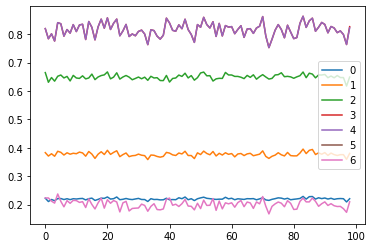

In [32]:
# All layers
for o in outp_mean: 
    plt.plot(o)
plt.legend(range(7))

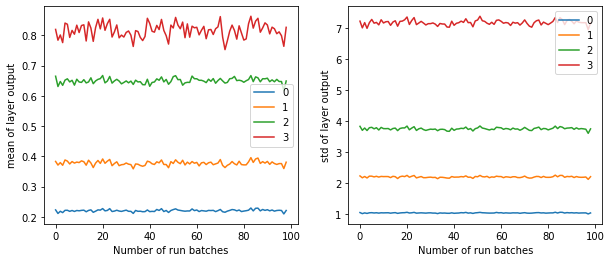

In [33]:
# Let's select the conv layers

fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))

for n, l in enumerate(model):
    if isinstance(l, nn.Sequential):
        ax0.plot(outp_mean[n])
        ax1.plot(outp_std[n])

for axis in [ax0,ax1]:
    axis.legend(range(4))
    axis.set_xlabel('Number of run batches')
    
ax0.set_ylabel('mean of layer output')
ax1.set_ylabel('std of layer output');

## Hook Class and removing hooks

In [34]:
class Hook():
    """This class registers a new hook, collects information and removes the hook
    afterwards.
    """
    
    def __init__(self, layer, func):
        self.stats = ([],[])
        self.hook = layer.register_forward_hook(partial(func, self))
    
    def __del__(self):
        self.remove()
    
    def remove(self): 
        self.hook.remove()

In [35]:
class Hooks():
    """This class bundles multiple hooks and stores its information."""
    
    def __init__(self, layers, func):
        #self.collected_data = [[] for _ in layers]
        self.hooks = [Hook(l, func) for l in layers]
        
    def __enter__(self, *args):
        return self
    
    def __exit__(self, *args):
        self.remove()
        
    def __del__(self): 
        self.remove()
    
    def __repr(self):
        return self.hooks
    
    def remove(self): 
        for hook in self.hooks:
            hook.remove()

In [36]:
def collect_layer_data(hook, model, inp, outp):
    means, stds = hook.stats
    means.append(outp.data.mean())
    stds.append(outp.data.std())

In [37]:
def print_collected_data(cld):
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))

    for n, l in enumerate(model):
        if isinstance(l, nn.Sequential):
            ax0.plot(cld.hooks[n].stats[0])
            ax1.plot(cld.hooks[n].stats[1])

    for axis in [ax0,ax1]:
        axis.legend(range(4))
        axis.set_xlabel('Number of run batches')

    ax0.set_ylabel('mean of layer output')
    ax1.set_ylabel('std of layer output');

In [38]:
hks = Hooks(model, collect_layer_data)

The validation accuracy for epoch 1 is: 0.9288, the loss is: 0.3894


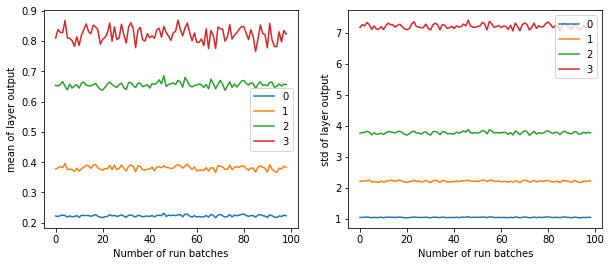

In [39]:
fit(1, dl_train)
print_collected_data(hks)

The validation accuracy for epoch 1 is: 0.9291, the loss is: 0.2737


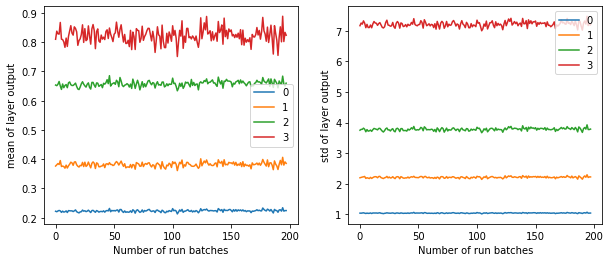

In [40]:
fit(1, dl_train)
print_collected_data(hks)

The validation accuracy for epoch 1 is: 0.9303, the loss is: 0.2248


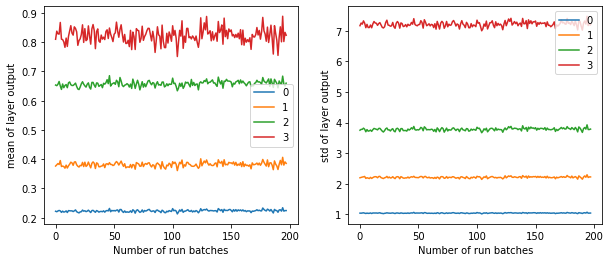

In [41]:
# Let's test if the hook can be removed.
hks.remove()
fit(1, dl_train)
print_collected_data(hks)

In [43]:
# Let's test if __exit__() works as expected

with Hooks(model, collect_layer_data) as hk:
    
    fit(1, dl_train)

The validation accuracy for epoch 1 is: 0.9306, the loss is: 0.2841


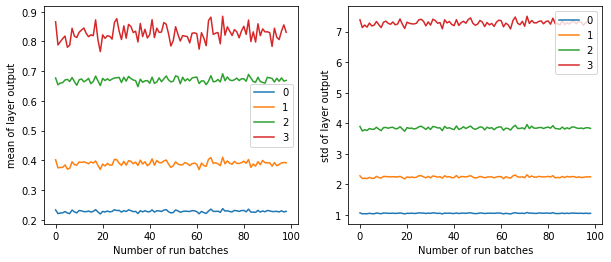

In [44]:
print_collected_data(hk)

The validation accuracy for epoch 1 is: 0.9320, the loss is: 0.2253


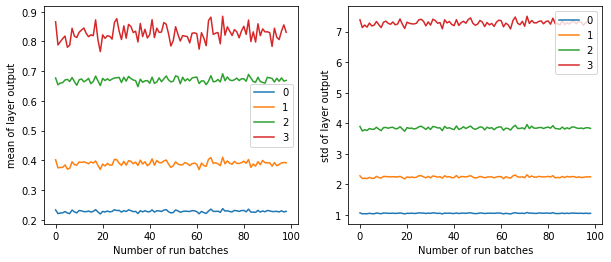

In [45]:
# Test if the hooks were really removed
fit(1, dl_train)
print_collected_data(hk)

In [46]:
# Fin